### 본 듀토리얼은 CIFAR10 데이터에 대해 Pseudo Labeling Methods 2가지와 VGG16을 비교한 내용을 담고 있다.

#### Self-Training
Self-Training은 준지도학습(semi-supervised) 방법 중에서 가장 간단한 방법이다. 먼저 소량의 레이블이 존재하는 데이터(labeled data)로 모델을 학습시킨다. 이후 이 모델을 가지고 레이블이 없는 데이터(unlabeled data)를 예측한다.(pseudo labeling) 이후 labeled data와 pseudo labeled data를 활용하여 모델을 재학습한다. Unlabeled data를 예측하여 pseudo label을 할당하는 모델을 ‘Teacher Model’이라고 하고, Labeled data와 pseudo labeed data를 활용하여 학습하는 모델을 ‘Student Model’이라고 한다. Self-Training 방법은 teacher model의 성능이 좋지 않으면, 신뢰도 높은 pseudo label을 확보하지 못한다. 즉, 적절한 semi-supervised learning이 이뤄지기 어려운 것이다. 원래는 소량의 label data만을 사용해야 하지만 teacher model의 영향력을 고려하여 label data를 1000개, unlabeled data(pseudo label dataset)를 1000개로 하였다. 이후 500개의 test dataset을 가지고 평가를 하였다. 

#### Noisy student
Noisy Student는 teacher model과 크기가 같거나 더 큰 student model을 사용하는, knowledge distillation 에 영감을 받은 semi-supervised 방법론이다. 먼저 Teacher Model을 labeled image로 학습 후 unlabeled data의 pseudo label을 생성한다. 이후 teacher model보다 크기가 큰 모델을 student model로 사용하여 labeled data+unlabeled data(pseudo label dataset)로 학습한다. 마지막으로 학습된 student model을 새로운 teacher model로 활용한다. 데이터셋 분할은 self-training과 똑같이 하였으며 (1)Data Augmentation (2)Dropout (3)Stochastic Depth (4)Data filtering의 4가지 noise 방식을 추가하였다.

#### 결과 해석
Semi-supervised learning 방법론 두 가지를 실험해 보았다. 처음에 label data를 500개로 하였다가 너무 teacher model의 성능이 너무 떨어져서 1000개로 올렸었다. 아주 약간의 성능 변화만 있었을 뿐 큰 차이는 없었다. 이전에 실험했었던 supervised learning의 VGG16의 경우 epoch를 낮게하여 학습을 했을 때도 매우 높은 성능을 달성했었다. 해당 결과와 비교를 했을 때, semi-supervised learning 방법들은 크게 좋다고 보기는 어려울 것 같다.

In [4]:
import os
import cv2
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_util
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import classification_report

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
os.getcwd()

'c:\\Users\\RohSeungChan\\.git\\Business-Analytics\\Business-Analytics\\Semi-supervised Learning'

In [7]:
TRAIN_DATADIR = r'C:\Users\RohSeungChan\.git\Business-Analytics\Business-Analytics\Semi-supervised Learning\CIFAR-10-images-master\train'
CATEGORIES = ['airplane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
"""train data 생성"""
def create_training_data(slice_num_start, slice_num_end, data_list):
    for i in range(len(CATEGORIES)):
        category = CATEGORIES[i]
        path = os.path.join(TRAIN_DATADIR, category)
        for img in os.listdir(path)[slice_num_start:slice_num_end]:
            img_array = np.fromfile(os.path.join(path, img), np.uint8)
            curImg = cv2.imdecode(img_array,  cv2.IMREAD_COLOR)
            data_list.append([curImg, i])

    return data_list

In [9]:
# load train data       
training_data = []     
training_dataset = create_training_data(0, 1000, training_data)

# teacher model train data
train_dataloader = data_util.DataLoader(training_dataset, batch_size=64, shuffle=True)

In [10]:
"""Psuedo data 생성"""
# load psuedo data
psuedo_data = []
psuedo_dataset = create_training_data(1000, 1500, psuedo_data)
psuedo_dataset = random.sample(psuedo_dataset, len(psuedo_dataset))

In [11]:
"""test data 생성"""
TEST_DATADIR = r'C:\Users\RohSeungChan\.git\Business-Analytics\Business-Analytics\Semi-supervised Learning\CIFAR-10-images-master\test'

def create_test_data(slice_num_start, slice_num_end, data_list):
    for i in range(len(CATEGORIES)):
        category = CATEGORIES[i]
        path = os.path.join(TEST_DATADIR, category)
        for img in os.listdir(path)[slice_num_start:slice_num_end]:
            img_array = np.fromfile(os.path.join(path, img), np.uint8)
            curImg = cv2.imdecode(img_array,  cv2.IMREAD_COLOR)
            data_list.append([curImg, i])

    return data_list

# load test data
test_dataset = []
test_dataset = create_test_data(0, 300, test_dataset)
test_dataset = random.sample(test_dataset, len(test_dataset))

In [12]:
"""베이스 라인"""
class Base_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        # self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(1176, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
"""teacher model 학습"""
#initialize teacher model
teacher = Base_net().to(device)
# model parameter
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher.parameters(), lr=0.001)
epoch = 150

loss_history = []
## train
for epoch in tqdm(range(epoch)):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs = torch.tensor(inputs.permute(0,3,1,2)).float().to(device)
        labels = labels.to(device)
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 통계를 출력합니다.
        running_loss += loss.item()
        # print('%s=> loss: %.3f' %(i, loss))
        loss_history.append(loss.cpu().detach())

print('Finished Training')


100%|██████████| 150/150 [01:36<00:00,  1.56it/s]

Finished Training


In [14]:
# # Load Model
load_module_PATH = r'model'  
teacher = Net()
teacher.load_state_dict(torch.load(load_module_PATH + 'cifar10_teacher.pt'))
teacher = teacher.to(device)

----

### Pseudo Labeling Methods : Self-training

In [15]:
"""Psuedo labeling"""
new_psuedo_dataset = []
for i, data in enumerate(psuedo_dataset, 0):
    # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
    inputs, labels = data
    inputs = torch.tensor(inputs).float().unsqueeze(0).permute(0, 3, 1, 2).to(device)

    # create pseudo label
    outputs = teacher(inputs)
    new_label = torch.softmax(outputs, -1)
    y = int(torch.argmax(new_label, dim=1))
    new_psuedo_dataset.append([np.array(inputs.squeeze(0).permute(1, 2, 0).cpu().detach().int()), y])

# create psuedo data (append train data with pseudo data)
student_dataset = training_dataset + new_psuedo_dataset
new_psuedo_dataloader = data_util.DataLoader(student_dataset, batch_size=64, shuffle=True)

  0%|          | 0/149 [00:00<?, ?it/s]c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 149/149 [02:28<00:00,  1.00it/s]

Finished Training


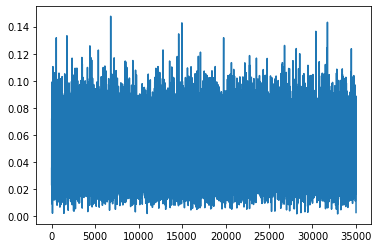

In [16]:
"""student model 학습"""
loss_history = []
## train
for epoch in tqdm(range(epoch)):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(new_psuedo_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs = torch.tensor(inputs.permute(0,3,1,2)).float().to(device)
        labels = labels.to(device)
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = teacher(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 통계를 출력합니다.
        running_loss += loss.item()
        # print('%s=> loss: %.3f' %(i, loss))
        loss_history.append(loss.cpu().detach())

print('Finished Training')
plt.plot(np.array(loss_history))

In [17]:
# 저장
save_module_PATH = r'model'
torch.save(teacher.state_dict(), save_module_PATH + 'cifar10_student.pt')

In [18]:
# 불러오기
load_module_PATH = r'model' 
student = Net()
student.load_state_dict(torch.load(load_module_PATH + 'cifar10_student.pt'))
student = student.to(device)

In [19]:
"""결과 확인"""
y_pred = []
y_true = []
for i, data in enumerate(test_dataset, 0):
    # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
    inputs, labels = data
    inputs = torch.tensor(inputs).float().unsqueeze(0).permute(0, 3, 1, 2).to(device)

    # create pseudo label
    outputs = student(inputs)
    new_label = torch.softmax(outputs, -1)
    y = int(torch.argmax(new_label, dim=1))
    y_pred.append(y)
    y_true.append(labels)

print(classification_report(y_true, y_pred, target_names=CATEGORIES))

              precision    recall  f1-score   support

    airplane       0.52      0.49      0.51       300
  automobile       0.53      0.55      0.54       300
        bird       0.34      0.35      0.34       300
         cat       0.27      0.25      0.26       300
        deer       0.35      0.38      0.37       300
         dog       0.36      0.34      0.35       300
        frog       0.50      0.56      0.53       300
       horse       0.50      0.50      0.50       300
        ship       0.60      0.60      0.60       300
       truck       0.48      0.46      0.47       300

    accuracy                           0.45      3000
   macro avg       0.45      0.45      0.45      3000
weighted avg       0.45      0.45      0.45      3000



---

### Pseudo Labeling Methods : Noisy Student

In [20]:
"""Noisy student data 생성"""
student_dataset = training_dataset + new_psuedo_dataset
noisystudent_dataloader = data_util.DataLoader(student_dataset, batch_size=64, shuffle=True)

"""Noisy student model"""
class NoisyStudent(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.fc1 = nn.Linear(288, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [21]:
"""teacher model 학습"""
#initialize teacher model
student_model = NoisyStudent().to(device)
# model parameter
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
epoch = 100

loss_history = []
## train
for epoch in tqdm(range(epoch)):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(noisystudent_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs = torch.tensor(inputs.permute(0,3,1,2)).float().to(device)
        labels = labels.to(device)
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = student_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 통계를 출력합니다.
        running_loss += loss.item()
        # print('%s=> loss: %.3f' %(i, loss))
        loss_history.append(loss.cpu().detach())

print('Finished Training')

100%|██████████| 100/100 [02:26<00:00,  1.47s/it]

Finished Training


In [22]:
"""noisy student data 생성"""
# load student data
pseudo_student_dataset = []
pseudo_student_dataset = create_training_data(1500, 2000, pseudo_student_dataset)
pseudo_student_dataset = random.sample(pseudo_student_dataset, len(pseudo_student_dataset))

"""Psuedo Labeling"""
new_pseudo_student_dataset = []
for i, data in enumerate(pseudo_student_dataset, 0):
    # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
    inputs, labels = data
    inputs = torch.tensor(inputs).float().unsqueeze(0).permute(0, 3, 1, 2).to(device)

    # create pseudo label
    outputs = teacher(inputs)
    new_label = torch.softmax(outputs, -1)
    y = int(torch.argmax(new_label, dim=1))
    new_pseudo_student_dataset.append([np.array(inputs.squeeze(0).permute(1, 2, 0).cpu().detach().int()), y])

# create psuedo data (append train data with pseudo data)
temp_dataset = student_dataset + new_pseudo_student_dataset
new_psuedo_student_dataloader = data_util.DataLoader(temp_dataset, batch_size=64, shuffle=True)

In [23]:
"""Student model 학습"""
loss_history = []
## train
for epoch in tqdm(range(epoch)):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(new_psuedo_student_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs = torch.tensor(inputs.permute(0,3,1,2)).float().to(device)
        labels = labels.to(device)
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = student_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 통계를 출력합니다.
        running_loss += loss.item()
        # print('%s=> loss: %.3f' %(i, loss))
        loss_history.append(loss.cpu().detach())

print('Finished Training')

  0%|          | 0/99 [00:00<?, ?it/s]c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 99/99 [03:12<00:00,  1.94s/it]

Finished Training


In [24]:
"""Self-Training 확인"""
y_pred = []
y_true = []
for i, data in enumerate(test_dataset, 0):
    # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
    inputs, labels = data
    inputs = torch.tensor(inputs).float().unsqueeze(0).permute(0, 3, 1, 2).to(device)

    # create pseudo label
    outputs = student_model(inputs)
    new_label = torch.softmax(outputs, -1)
    y = int(torch.argmax(new_label, dim=1))
    y_pred.append(y)
    y_true.append(labels)

print(classification_report(y_true, y_pred, target_names=CATEGORIES))

              precision    recall  f1-score   support

    airplane       0.56      0.48      0.52       300
  automobile       0.65      0.65      0.65       300
        bird       0.41      0.23      0.30       300
         cat       0.28      0.23      0.25       300
        deer       0.44      0.43      0.44       300
         dog       0.36      0.43      0.39       300
        frog       0.47      0.73      0.57       300
       horse       0.58      0.54      0.56       300
        ship       0.61      0.63      0.62       300
       truck       0.51      0.54      0.52       300

    accuracy                           0.49      3000
   macro avg       0.49      0.49      0.48      3000
weighted avg       0.49      0.49      0.48      3000

